# scPLAN Annotation Guidelines

In this tutorial, we will introduce the basic usage of scPLAN on annotation task. 

## 1. Module dependencies 

In [ ]:
from scplan.PLL import PartialLabelLearning
from scplan.Param import Param
from scplan.Encoder import ZINBEncoder
from scplan.DataWork.scRNA import AnnotationDataset 
from scplan.DataWork.sankey import sankey
import lightning.pytorch as pl
import scanpy as sc
from lightning.pytorch.loggers import MLFlowLogger
import pandas as pd
import matplotlib.pyplot as plt

## 2. Parameter settings and dataset initialize

In this section, we will introduce some essential parameters for scPLAN

In [3]:
## Parameter settings 
param = Param()                                          # Initialize param class
param.datapath = "/home/bili/Lernen/PLL/Data/Brain/src/" # Specify data path
param.target = "Segerstolpe.h5ad"                        # Specify target data
param.ref = "Baron_Segerstolpe.h5ad"                     # Specify reference data
param.pretrain_epoch = 20                                # Maximal ZINB pretraining epochs
param.enc_dim = [256]                                    # Encoder hidden layer size 
param.dec_dim = [256]                                    # Decoder hidden layer size
param.latent_dim = 64                                    # Latent size
param.epochs = [30,60,100]                               # Total epochs 
param.batch_size = 512                                   # Config training process
param.moco_queue = 2048                                  # Config pool size for contrastive learning
param.lr = 1e-4                                          # Overall learning rate
param.loss_weight = 0.43                                 # Contrastive loss weight
param.recon_weight = 0.5                                 # Reconstruction loss weight
param.device = [0]                                       # CUDA device for training

## Dataset initialization
dataset = AnnotationDataset(data_path=param.datapath,target=param.target,ref=param.ref)
part_Y,cell_dic = dataset.initialize()
param = dataset.updateParams(param)
plan = PartialLabelLearning(param)

/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/preprocessing/_combat.py:199: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_info = model.groupby(key).indices.values()
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/preprocessing/_combat.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_items = model.groupby(batch_key).groups.items()
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


No reference tree provided, generating tree
Max_t:9,SS:0.09745354001719386
Max_t:10,SS:0.09745354001719386
Max_t:11,SS:0.09745354001719386
Max_t:12,SS:0.09745354001719386
ROOT
├── Cluster_1
│   ├── pancreatic A cell
│   ├── pancreatic D cell
│   ├── pancreatic PP cell
│   └── type B pancreatic cell
├── Cluster_2
│   ├── pancreatic acinar cell
│   └── pancreatic ductal cell
├── Cluster_3
│   └── pancreatic epsilon cell
├── Cluster_4
│   ├── endothelial cell
│   └── pancreatic stellate cell
├── Cluster_5
│   └── Schwann cell
├── Cluster_6
│   ├── macrophage
│   └── mast cell
└── Cluster_7
    └── T cell

tensor([4., 6., 3., 5., 5., 0., 0., 0., 1., 1., 2., 3., 0.])


## 3. Initialization of scPLAN module


In [4]:
plan.Setup(ZINBEncoder,pretrain=True,dataset=dataset)

runid: e6d6a9c9559242629120abc7472ad25c


/home/bili/Lernen/PLL/plan/DataWork/utils.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.size_factor = torch.Tensor(values.obs["size_factor"])      # Compute size factor
/home/bili/Lernen/PLL/plan/DataWork/utils.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.cell_label = torch.Tensor(values.obs["cell_label"]).int()  # Initialize ground truth label
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-package

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 512. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.00026302679918953814
Restoring states from the checkpoint path at /home/bili/Lernen/PLL/Experiments/MultiDataset/Baron_Annotation/.lr_find_9fe321f8-d64c-443a-93cd-7a02a0ced87d.ckpt
Restored all states from the checkpoint at /home/bili/Lernen/PLL/Experiments/MultiDataset/Baron_Annotation/.lr_find_9fe321f8-d64c-443a-93cd-7a02a0ced87d.ckpt

  | Name  | Type            | Params
------------------------------------------
0 | AE    | ZINBAutoEncoder | 2.1 M 
1 | zloss | ZINBLoss        | 0     
------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.353     Total estimated model params siz

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## 4. scPLAN training

In this section we train scPLAN in a two-layer scheme

In [5]:
first_stage_trainer = pl.Trainer(max_epochs=param.epochs[-2], devices=param.device)
first_stage_trainer.fit(plan)
first_stage_trainer.save_checkpoint("stage1.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory /home/bili/Lernen/PLL/Experiments/MultiDataset/Baron_Annotation/11/e6d6a9c9559242629120abc7472ad25c/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | Model | 4.2 M 
--------------------------------
2.1 M     Trainable params
2.1 M     Non-trainable params
4.2 M     Total params
16.706    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


In [6]:
pred_loader = dataset.load(batch_size=param.batch_size, train=False)
pred_trainer = pl.Trainer(devices=param.device)
stage_1_pred_out = pred_trainer.predict(plan, pred_loader)
stage_1_pred_data = plan.getPredictions(stage_1_pred_out)

/home/bili/Lernen/PLL/plan/DataWork/utils.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.size_factor = torch.Tensor(values.obs["size_factor"])      # Compute size factor
/home/bili/Lernen/PLL/plan/DataWork/utils.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.cell_label = torch.Tensor(values.obs["cell_label"]).int()  # Initialize ground truth label
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/log

Predicting: |          | 0/? [00:00<?, ?it/s]

In [7]:
stage_2_trainer = pl.Trainer(max_epochs=param.epochs[-1], devices=param.device)
stage_2_trainer.fit(plan, ckpt_path="stage1.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory /home/bili/Lernen/PLL/Experiments/MultiDataset/Baron_Annotation/11/e6d6a9c9559242629120abc7472ad25c/checkpoints exists and is not empty.
Restoring states from the checkpoint path at stage1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | Model | 4.2 M 
--------------------------------
2.1 M     Trainable params
2.1 M     Non-trainable params
4.2 M     Total params
16.706    Total estimated model params size (MB)
Restored all states from the checkpoint at stage1.ckpt
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (18) is smaller than the logging interva

Training: |          | 0/? [00:00<?, ?it/s]

Updating label clusters
tensor([ 9., 12.,  7., 10., 11.,  0.,  1.,  2.,  4.,  5.,  6.,  8.,  3.])


`Trainer.fit` stopped: `max_epochs=100` reached.


In [8]:
pred_loader = dataset.load(batch_size=param.batch_size, train=False)
pred_trainer = pl.Trainer(devices=param.device)
stage_2_pred_out = pred_trainer.predict(plan, pred_loader)
stage_2_pred_data = plan.getPredictions(stage_2_pred_out)

/home/bili/Lernen/PLL/plan/DataWork/utils.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.size_factor = torch.Tensor(values.obs["size_factor"])      # Compute size factor
/home/bili/Lernen/PLL/plan/DataWork/utils.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.cell_label = torch.Tensor(values.obs["cell_label"]).int()  # Initialize ground truth label
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

## 5. Downstream analysis

After training, we could extract scPLAN's latent and perform downstream analysis

In [9]:
sc.pp.neighbors(stage_1_pred_data, use_rep="latent")
sc.tl.umap(stage_1_pred_data)
sc.pp.neighbors(stage_2_pred_data, use_rep="latent")
sc.tl.umap(stage_2_pred_data)

/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/umap/distances.py:

Accurarcy: 0.9663461538461539


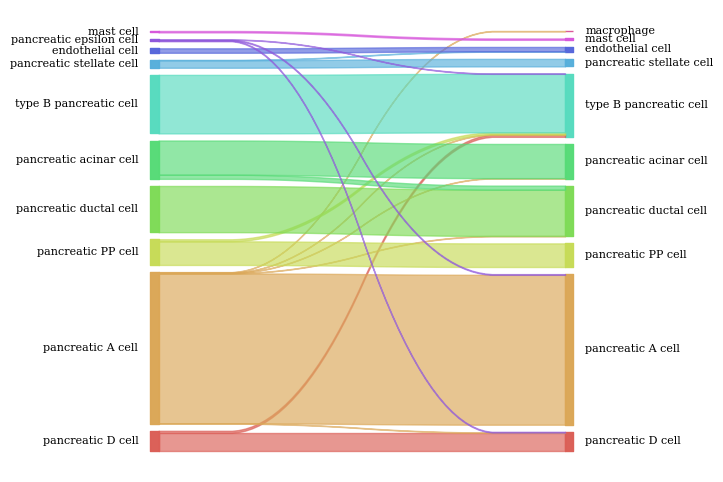

In [12]:
stage_1_target_pred_data = stage_1_pred_data[stage_1_pred_data.obs['dataset'] == "target"]
stage_2_target_pred_data = stage_2_pred_data[stage_1_pred_data.obs['dataset'] == "target"]
true_label = stage_2_target_pred_data.obs["cell_type"].to_numpy()
pred_label = stage_2_target_pred_data.obs["pred"].to_numpy()
df = pd.DataFrame([true_label, pred_label]).T
accuracy = (pred_label == true_label).sum() / len(df)
print("Accurarcy: {}".format(accuracy))
fig = sankey(true_label, pred_label, aspect=150, fontsize=8)

/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


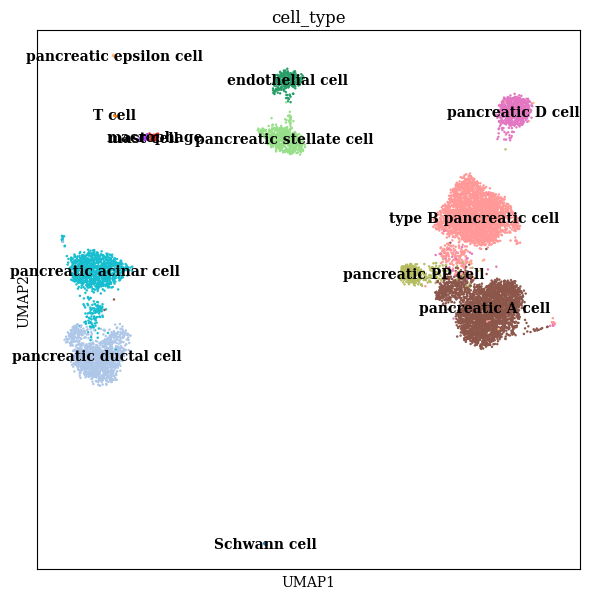

/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


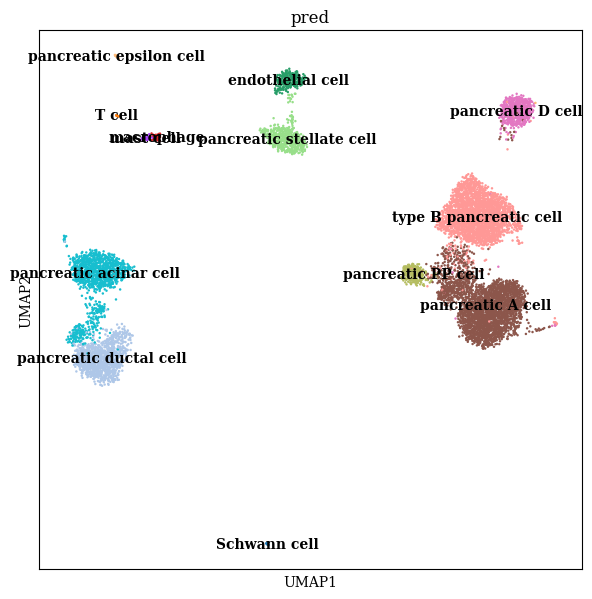

/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


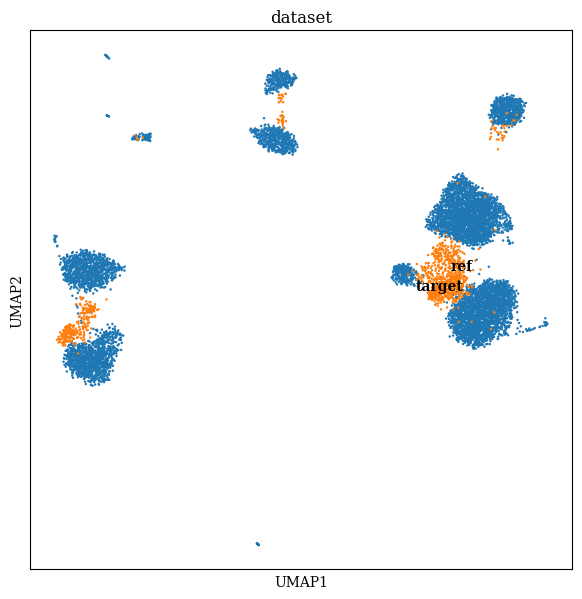

/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


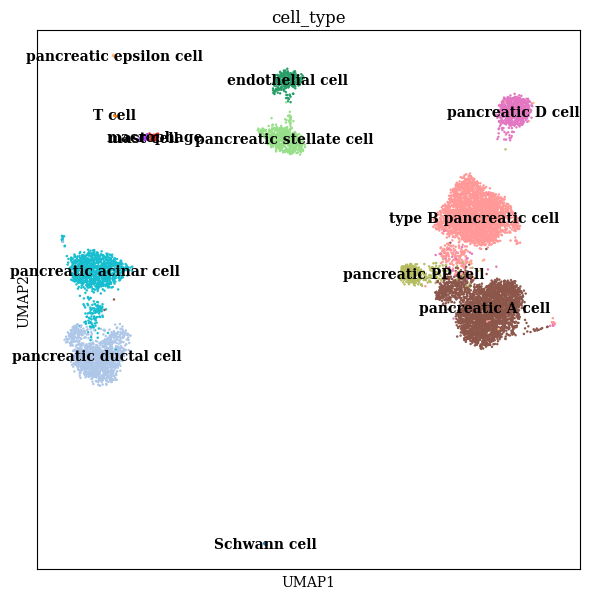

/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


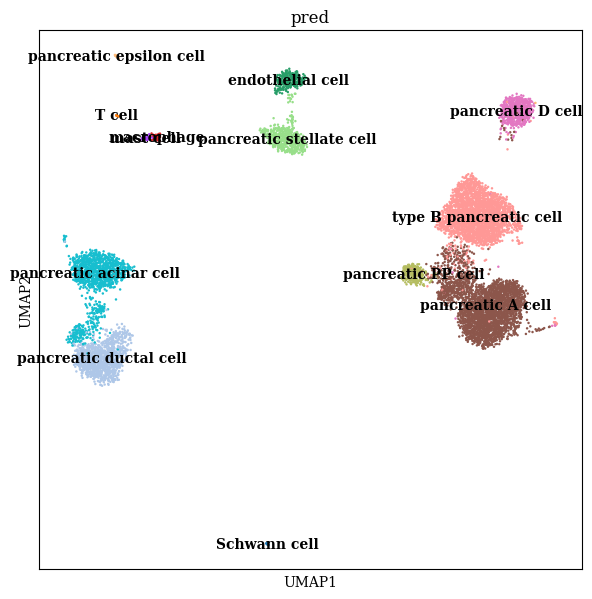

/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


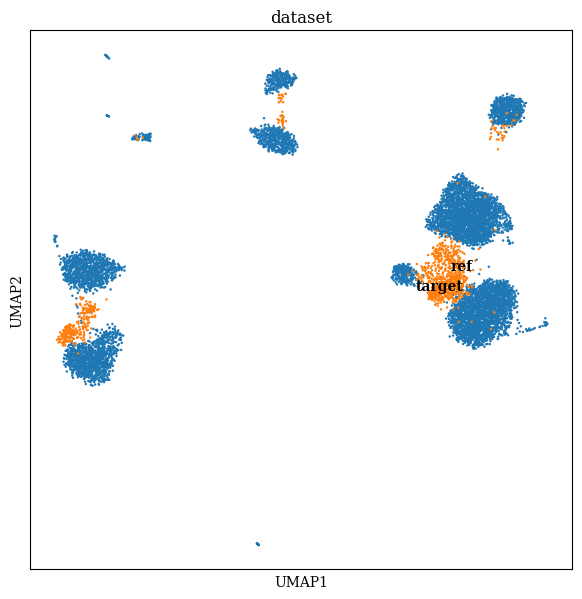

/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


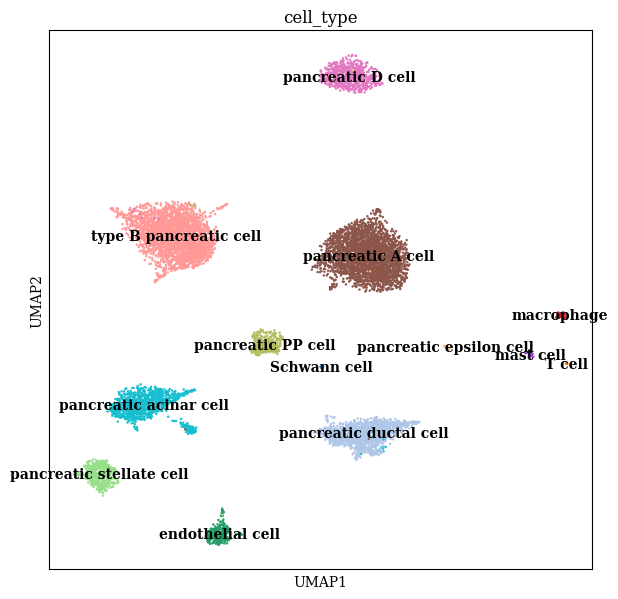

/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


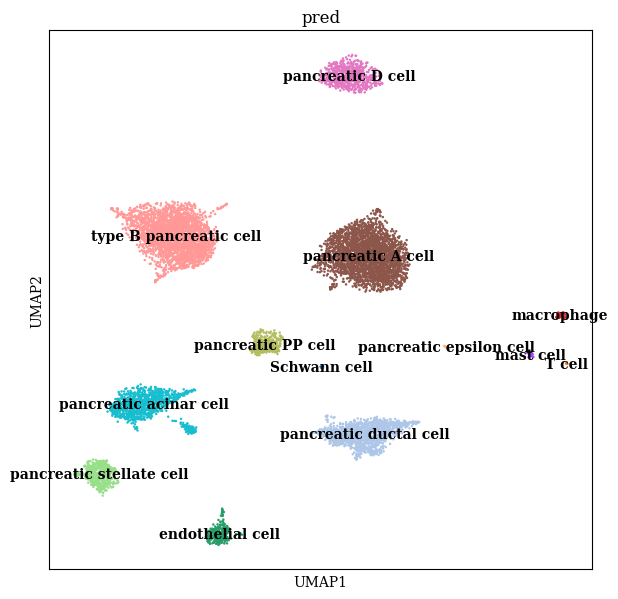

/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


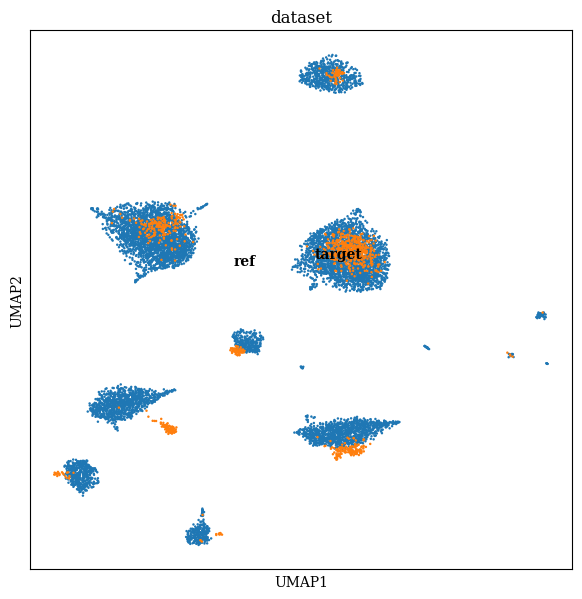

/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


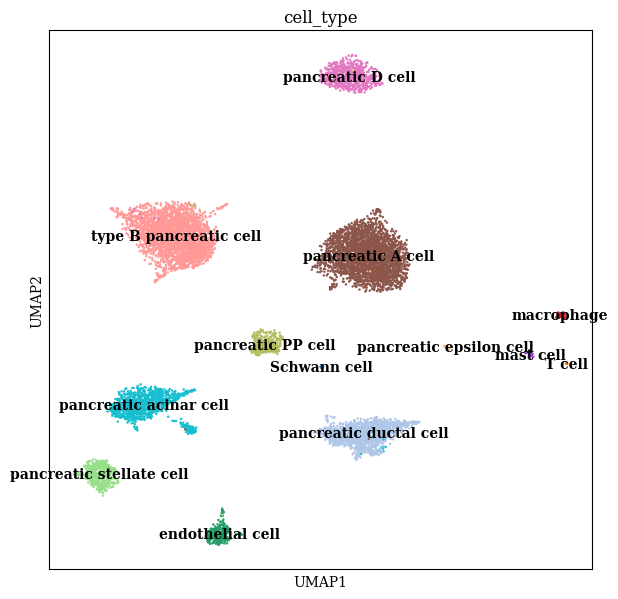

/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


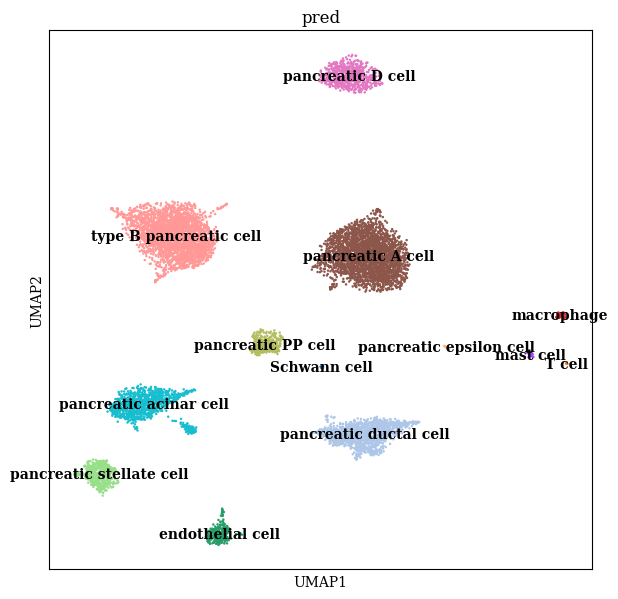

/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bili/Apps/Mamba/envs/PLL/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


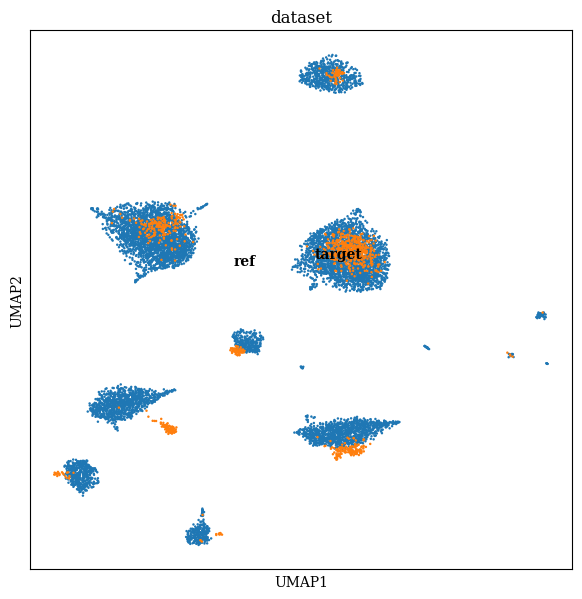

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sc.pl.umap(stage_1_pred_data, color='cell_type', ax=ax, legend_loc="on data")
logger.experiment.log_figure(run_id=logger.run_id, figure=fig, artifact_file="fig/Stage_1_latent_ct_all.png")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sc.pl.umap(stage_1_pred_data, color='pred', ax=ax, legend_loc="on data")
logger.experiment.log_figure(run_id=logger.run_id, figure=fig, artifact_file="fig/Stage_1_latent_pred_all.png")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sc.pl.umap(stage_1_pred_data, color='dataset', ax=ax, legend_loc="on data")
logger.experiment.log_figure(run_id=logger.run_id, figure=fig, artifact_file="fig/Stage_1_latent_source_all.png")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sc.pl.umap(stage_1_pred_data, color='cell_type', ax=ax, legend_loc="on data")
logger.experiment.log_figure(run_id=logger.run_id, figure=fig, artifact_file="fig/Stage_1_latent_ct_target.png")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sc.pl.umap(stage_1_pred_data, color='pred', ax=ax, legend_loc="on data")
logger.experiment.log_figure(run_id=logger.run_id, figure=fig, artifact_file="fig/Stage_1_latent_pred_target.png")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sc.pl.umap(stage_1_pred_data, color='dataset', ax=ax, legend_loc="on data")
logger.experiment.log_figure(run_id=logger.run_id, figure=fig, artifact_file="fig/Stage_1_latent_source_target.png")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sc.pl.umap(stage_2_pred_data, color='cell_type', ax=ax, legend_loc="on data")
logger.experiment.log_figure(run_id=logger.run_id, figure=fig, artifact_file="fig/Stage_2_latent_ct_all.png")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sc.pl.umap(stage_2_pred_data, color='pred', ax=ax, legend_loc="on data")
logger.experiment.log_figure(run_id=logger.run_id, figure=fig, artifact_file="fig/Stage_2_latent_pred_all.png")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sc.pl.umap(stage_2_pred_data, color='dataset', ax=ax, legend_loc="on data")
logger.experiment.log_figure(run_id=logger.run_id, figure=fig, artifact_file="fig/Stage_2_latent_source_all.png")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sc.pl.umap(stage_2_pred_data, color='cell_type', ax=ax, legend_loc="on data")
logger.experiment.log_figure(run_id=logger.run_id, figure=fig, artifact_file="fig/Stage_2_latent_ct_target.png")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sc.pl.umap(stage_2_pred_data, color='pred', ax=ax, legend_loc="on data")
logger.experiment.log_figure(run_id=logger.run_id, figure=fig, artifact_file="fig/Stage_2_latent_pred_target.png")
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sc.pl.umap(stage_2_pred_data, color='dataset', ax=ax, legend_loc="on data")
logger.experiment.log_figure(run_id=logger.run_id, figure=fig, artifact_file="fig/Stage_2_latent_source_target.png")